### Analysis of the LFQ single-cell dataset generated at DTU with ASTRAL 

In [3]:
#Importing packages 
import pandas as pd 
import numpy as np
import os 
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from scipy import stats
from scipy.stats import mstats
sns.set_style("ticks")

myColors = ["#7400b8","#6930c3","#5e60ce","#5390d9","#4ea8de","#48bfe3","#56cfe1","#64dfdf","#72efdd","#80ffdb"]

/Users/valdemaras/Programs/miniconda/miniconda3/envs/singlecell/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#Data 
sc = pd.read_csv("data/Exp5/scDataset_proteins.tsv",sep = "\t", decimal = ",") # actually this norma_data is raw data 
peptides = pd.read_csv("data/Exp5/scDataset_peptides.tsv",sep = "\t", decimal = ",") # actually this norma_data is raw data 
sc_data = sc.drop(columns = ['PG.Genes'])
sc_data = sc_data.set_index('PG.ProteinGroups')
sc_data.columns = sc_data.columns.str.extract(r'scHEK__(.*)\.raw')[0].values # set columns to file name 

#Import FACS data 
facs = pd.read_csv('data/Exp5/Plate_0003.csv', sep = '\,')
queue = pd.read_csv('data/Exp5/scHEK_plate1.csv')
queue['Position'] = queue['Position'].str.replace('R:', '')
facs

/var/folders/fk/ycgfqq1520l3t9l7gs4wsjyr0000gp/T/ipykernel_3179/101038121.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  facs = pd.read_csv('data/Exp5/Plate_0003.csv', sep = '\,')


,Time,FSC-A,FSC-W,FSC-H,SSC-A,SSC-W,SSC-H,PE-Cy5-A,Row,Column,Position
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28.555413,144362.937500,96139.390625,77985.828125,66813.062500,70047.398438,45210.488281,100.192871,1.0,1.0,A1
2,28.845005,144334.265625,103908.234375,74801.023438,124589.429688,86878.515625,64263.750000,208.191376,1.0,2.0,A2
3,29.149156,147658.796875,111603.148438,76296.578125,117691.906250,113635.507812,55107.136719,247.682617,1.0,3.0,A3
4,29.469451,132629.187500,111801.328125,65525.523438,110102.695312,91526.859375,55934.406250,271.234253,1.0,4.0,A4
...,...,...,...,...,...,...,...,...,...,...,...
380,142.050491,134480.781250,99946.976562,71604.789062,69596.109375,81870.421875,37380.855469,156.639038,16.0,5.0,P5
381,142.357944,118157.000000,92784.460938,66461.070312,44122.734375,66570.601562,27372.660156,75.165939,16.0,4.0,P4
382,142.661007,129631.109375,103299.359375,68771.835938,76605.171875,79323.218750,40467.746094,139.673706,16.0,3.0,P3
383,142.925804,133695.859375,101865.593750,74043.179688,96621.507812,78937.648438,56192.421875,199.566879,16.0,2.0,P2


In [5]:
class proteinQuant:

    def __init__(self, ms_data, facs_data):
        #Save the raw input data here 
        self.ms_data = ms_data
        self.facs_data = facs_data


        #Run these function as soon as the object is created 
        self.extract_quant()
        self.cellSummary()
        self.QC_filter()
        #Generate a quant table from the MS data 
    def extract_quant(self):
        quant = self.ms_data.drop(columns = ['PG.Genes']) # drop the gene column
        quant = quant.set_index('PG.ProteinGroups')
        quant.columns = quant.columns.str.extract(r'] (.*)\.raw')[0].values
        self.quant = quant.replace('Filtered', np.nan).apply(pd.to_numeric)
    
    def cellSummary(self):
        detected_proteins = (self.quant > 0).sum(axis=0).values
        Intensity = self.quant.apply(lambda x: np.log2(np.nanmedian(x)), axis = 0).values
        FileName = self.quant.columns
        CellID = ['cell_' + str(i) for i in list(range(self.quant.shape[1]))] # generate an arbitrary cell ID 
        #Mark Cell bellow QC
        self.summary = pd.DataFrame(
                      {'File_Name': FileName,
                       'CellID': CellID,
                       'Position': FileName.str.extract(r'scHEK__(.*)')[0].values, 
                      'Detected_Proteins' : detected_proteins,
                      'Intensity': Intensity,
                      'H4': self.quant.loc['P62805',:],
                      'H4_norm': np.log2(self.quant.loc['P62805',:]/self.quant.loc['P62805',:].median()),
                    })
        #self.summary['QC_Pass'] = np.where((self.summary.Intensity < 9) & (self.summary.Detected_Proteins > 2500), True, False)
        self.summary['QC_Pass'] = np.where((np.abs(self.summary.H4_norm) < 2) & (self.summary.Detected_Proteins > 2000), True, False)
        self.summary['Potential_outlier'] = np.where((np.abs(self.summary.H4_norm) > 1.3) & (self.summary.Detected_Proteins > 2000), True, False)

    # Add FACS data, this is kept as a separate function incase the FACS data is not presenet for now
    def addFACS(self):
        #self.summary = pd.merge(self.summary, self.facs_data, how='left', left_on = 'File_Name', right_on = 'File Name').drop(columns=['File Name'])
        self.summary = pd.merge(self.summary, self.facs_data, how='left', on = 'Position')
    def QC_filter(self):
        self.quant_filtered = self.quant.loc[:,self.summary.QC_Pass.values]
        

    def impute_values(self):
      #Missing value imputation 
      totalCells = self.quant_filtered.shape[1] # get total number of cells analyzed
      missingInRow = pd.DataFrame(totalCells - self.quant_filtered.isnull().sum(axis = 1))
      
      missingInRow['to_impute'] = (missingInRow[0]/totalCells) > 0.5
      quant_imputed = self.quant_filtered.loc[missingInRow['to_impute'],:]
      #Imputing missing values with knn 
      from sklearn.impute import KNNImputer
      imputer = KNNImputer(n_neighbors=5, weights="uniform")
      self.quant_imputed = pd.DataFrame(np.exp(imputer.fit_transform(np.log(quant_imputed))))
      self.quant_imputed.columns = quant_imputed.columns
      self.quant_imputed.index = quant_imputed.index
    
sc_quant = proteinQuant(sc, facs)
sc_quant.addFACS()
sc_quant.impute_values()

/Users/valdemaras/Programs/miniconda/miniconda3/envs/singlecell/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


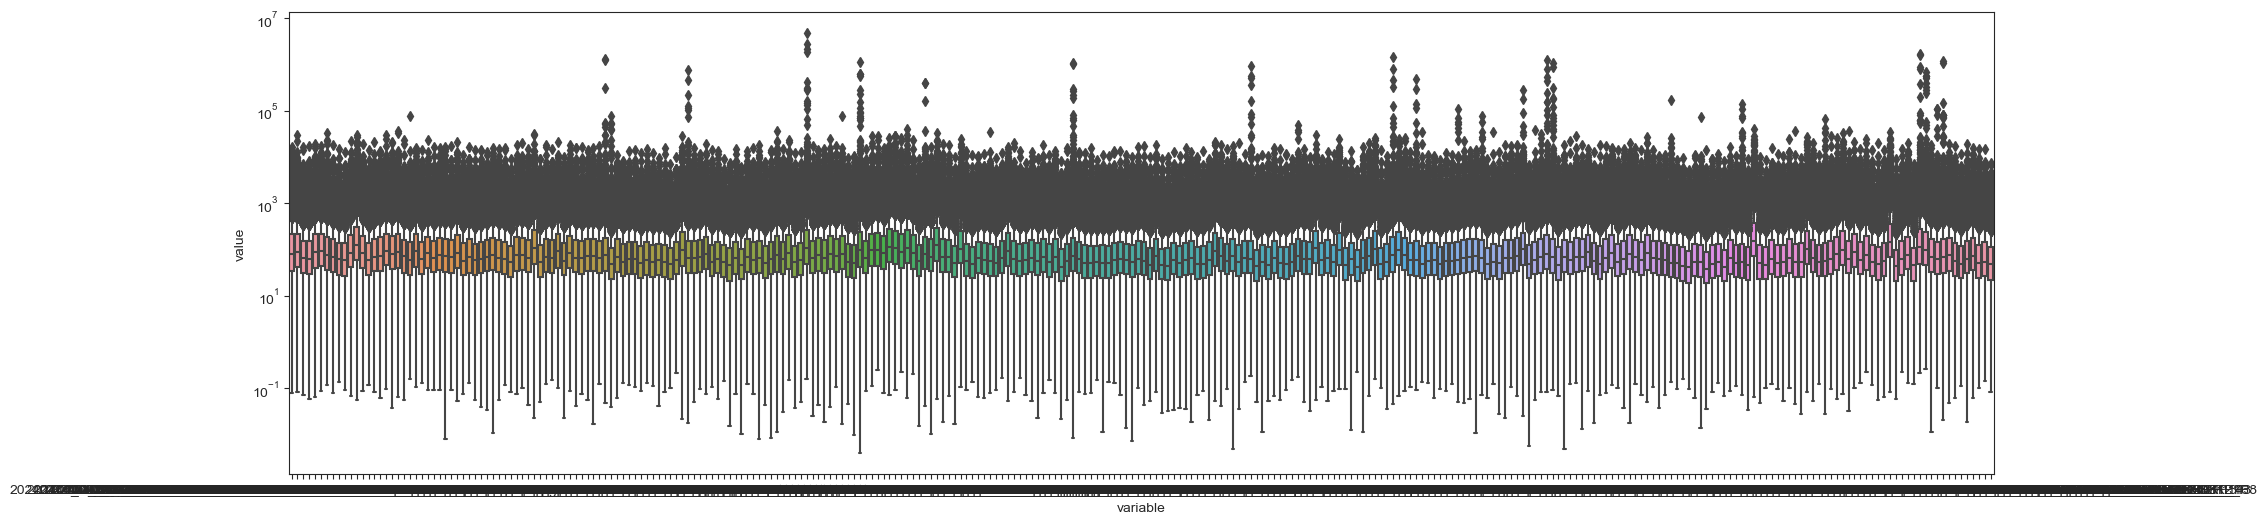

In [6]:
plt.subplots(figsize=(22,6))
g = sns.boxplot(data=pd.melt(sc_quant.quant_filtered), x = 'variable', y = 'value')
g.set_yscale("log")

<AxesSubplot:xlabel='H4_norm', ylabel='Count'>

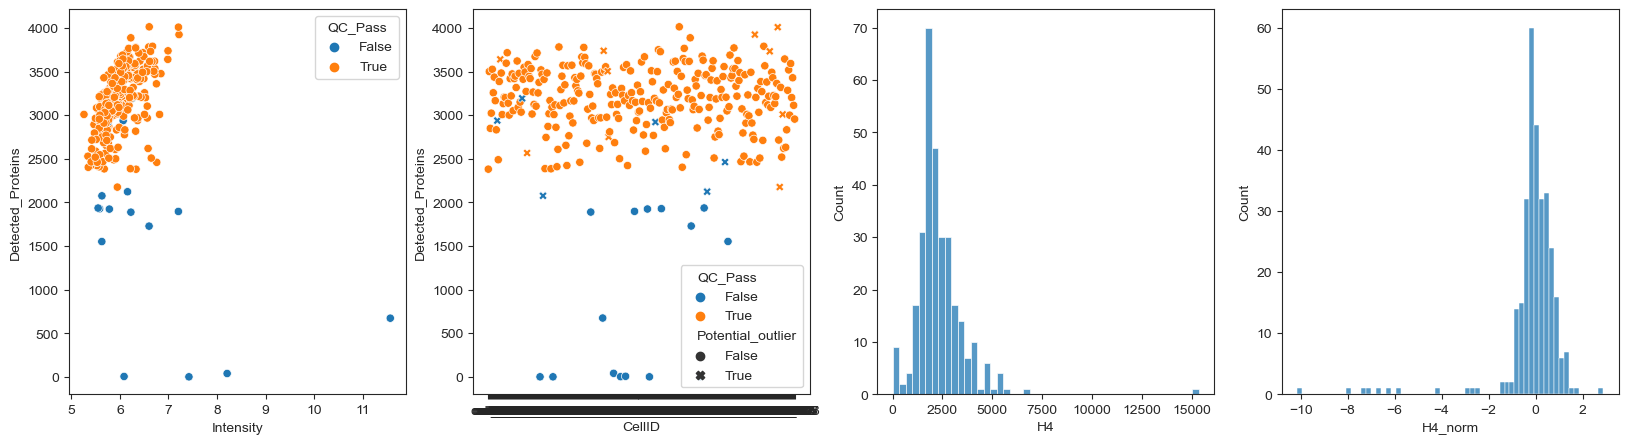

In [7]:
fig, axes = plt.subplots(1,4,figsize=(20,5), facecolor = "w")

sns.scatterplot(data = sc_quant.summary, y = 'Detected_Proteins', x = 'Intensity', hue = 'QC_Pass',ax =axes[0])
sns.scatterplot(data = sc_quant.summary, x = 'CellID', y = 'Detected_Proteins', hue = 'QC_Pass', style = 'Potential_outlier',ax =axes[1])
#sns.scatterplot(data = s#c_quant.summary, x = 'Intensity', y = 'Detected_Proteins', hue = 'H4',ax =axes[2])
sns.histplot(data = sc_quant.summary, x = 'H4', ax =axes[2])
sns.histplot(data = sc_quant.summary, x = 'H4_norm', ax =axes[3])

<AxesSubplot:xlabel='H4', ylabel='Count'>

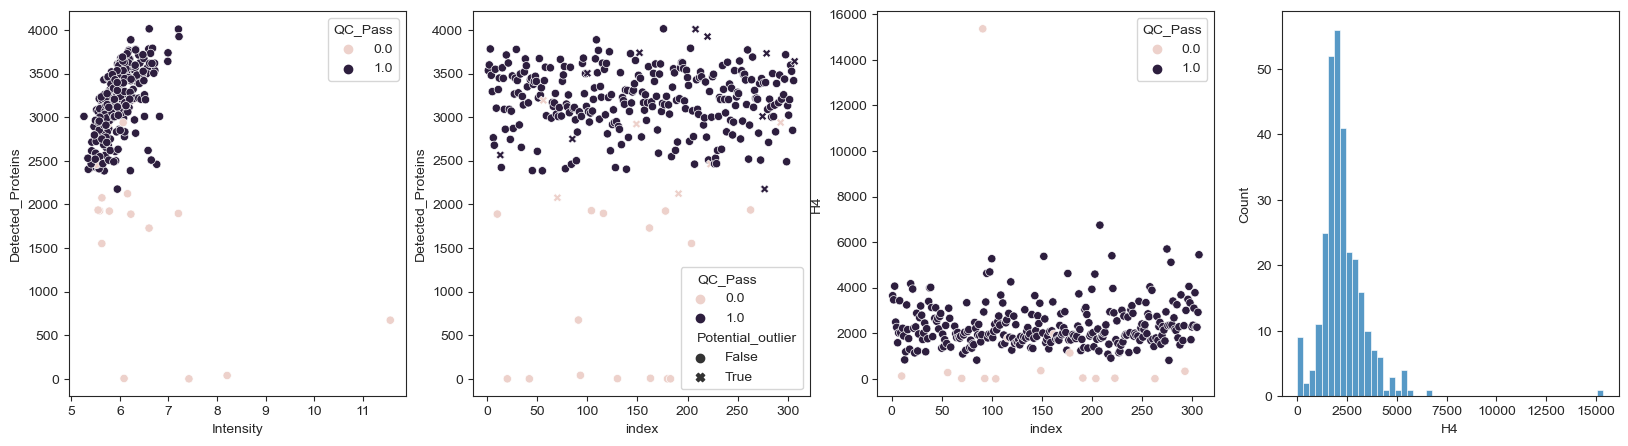

In [8]:
summary2 = sc_quant.summary.merge(queue, on = 'Position', how = 'right').reset_index()

fig, axes = plt.subplots(1,4,figsize=(20,5), facecolor = "w")

sns.scatterplot(data = summary2, y = 'Detected_Proteins', x = 'Intensity', hue = 'QC_Pass',ax =axes[0])
sns.scatterplot(data = summary2, x = 'index', y = 'Detected_Proteins', style = 'Potential_outlier', hue = 'QC_Pass',ax =axes[1])
sns.scatterplot(data = summary2, x = 'index', y = 'H4', ax =axes[2], hue  = 'QC_Pass')
sns.histplot(data = summary2, x = 'H4', ax =axes[3])

<AxesSubplot:xlabel='FSC-H', ylabel='FSC-W'>

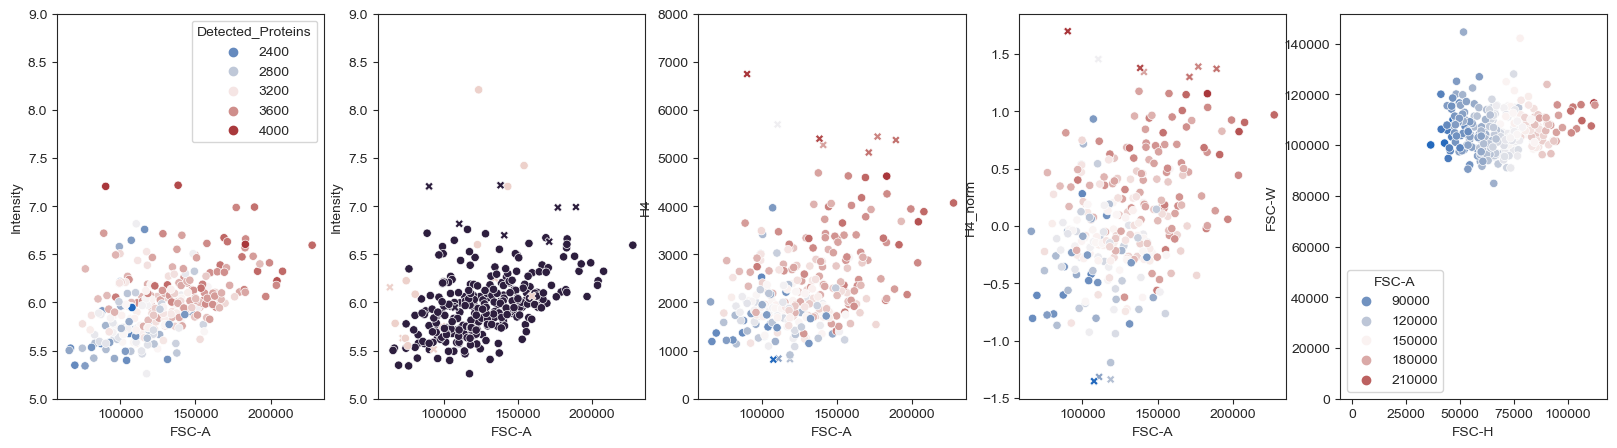

In [9]:
fig, axes = plt.subplots(1,5,figsize=(20,5), facecolor = "w")

sns.scatterplot(data = summary2.loc[summary2.QC_Pass == True], y = 'Intensity', x = 'FSC-A', hue = 'Detected_Proteins',ax =axes[0], palette='vlag').set(ylim=(5, 9))
sns.scatterplot(data = summary2, y = 'Intensity', x = 'FSC-A', style = 'Potential_outlier', hue = 'QC_Pass',ax =axes[1], legend=False).set(ylim=(5, 9))
sns.scatterplot(data = summary2.loc[summary2.QC_Pass == True], y = 'H4', x = 'FSC-A', style = 'Potential_outlier', hue = 'Detected_Proteins',ax =axes[2], legend=False, palette = 'vlag').set(ylim=(0, 8000))
sns.scatterplot(data = summary2.loc[summary2.QC_Pass == True], y = 'H4_norm', x = 'FSC-A', style = 'Potential_outlier', hue = 'Detected_Proteins',ax =axes[3], legend=False, palette = 'vlag')
sns.scatterplot(data = summary2.loc[summary2.QC_Pass == True], x = 'FSC-H', y = 'FSC-W', ax =axes[4], hue  = 'FSC-A', palette='vlag')
sns.histplot(data = summary2, x = 'H4', ax =axes[4])

<AxesSubplot:xlabel='FSC-A', ylabel='Count'>

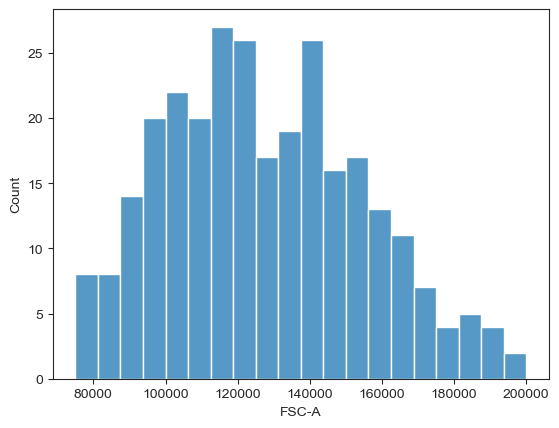

In [10]:
sns.histplot(data=summary2, x = 'FSC-A', bins =20, binrange=(75000, 200000))

### All proteins are positivelly correlated with cell size 

In [11]:
sc['PG.Genes'].values

sc.iloc[np.where(sc['PG.Genes'].str.contains('MCM') == True)[0],0:2]

,PG.ProteinGroups,PG.Genes
1295,P25205;P25205-2,MCM3
1452,P33991,MCM4
1453,P33992,MCM5
1454,P33993,MCM7
1707,P49736,MCM2
2507,Q14566,MCM6
4110,Q9BTE3;Q9BTE3-2,MCMBP


<AxesSubplot:xlabel='H4s', ylabel='PCNA'>

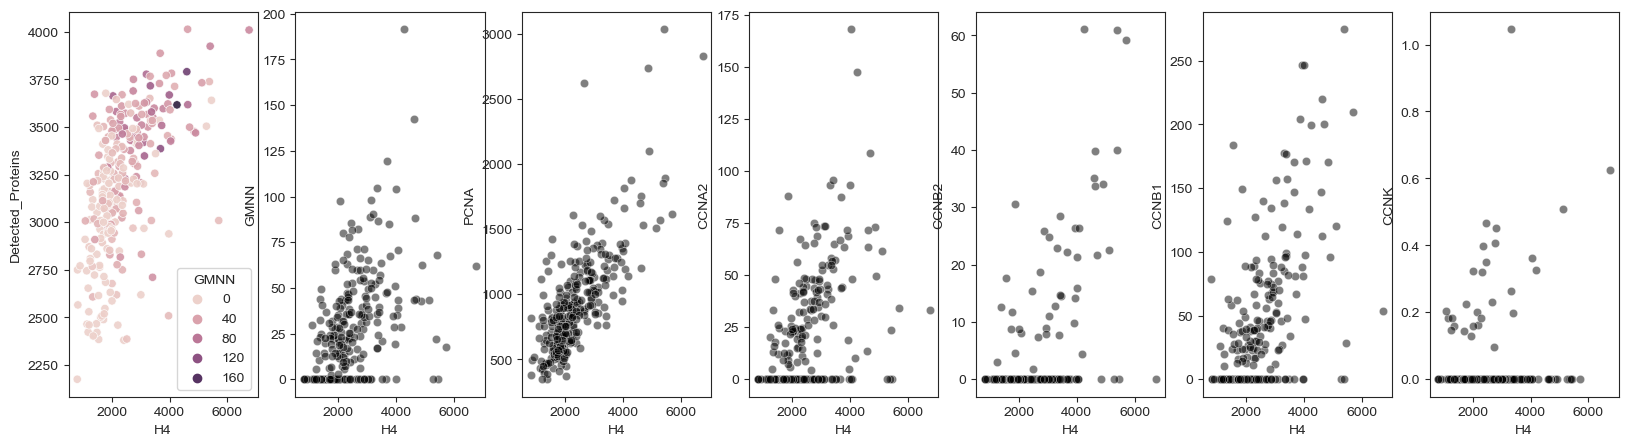

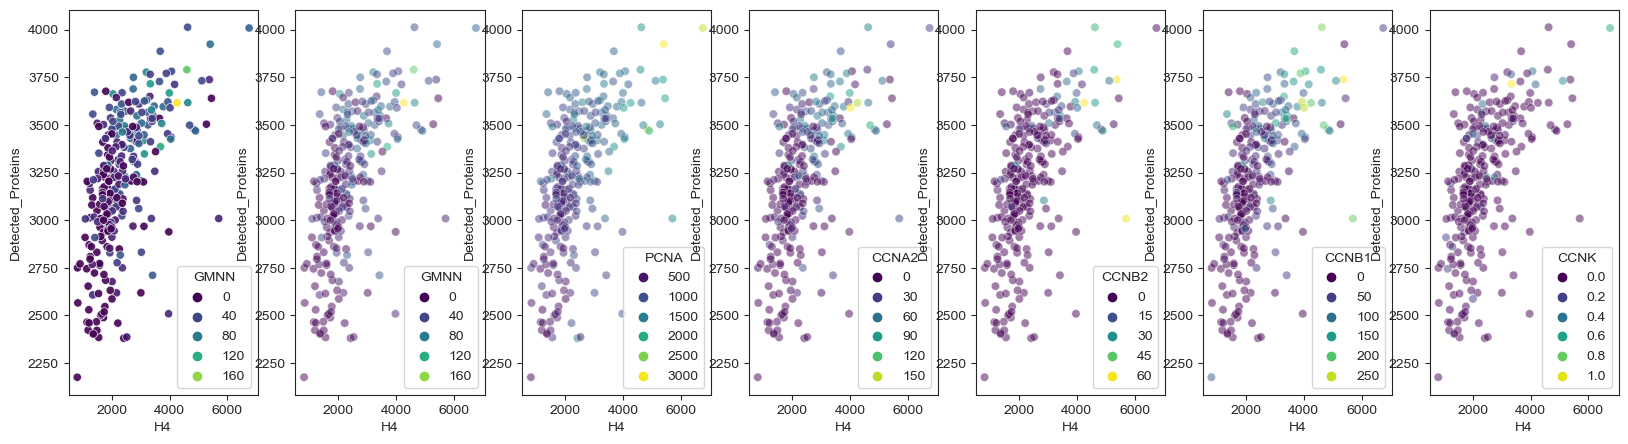

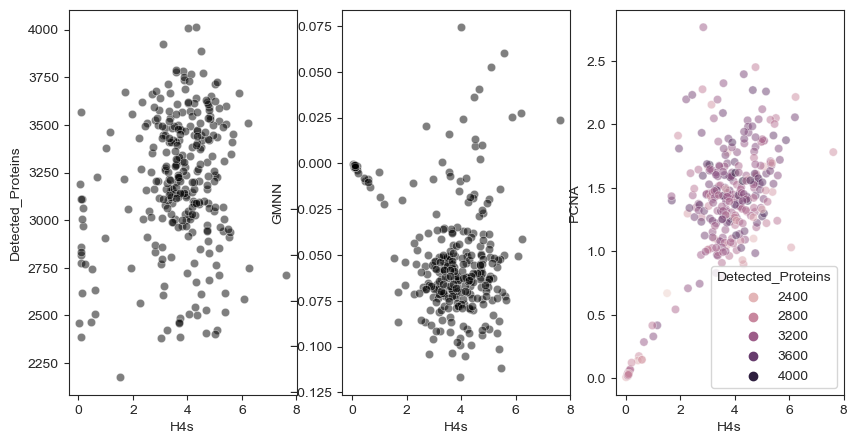

In [12]:

df = pd.DataFrame({'File_Name':  sc_quant.quant_filtered.columns,
                   'GMNN' : sc_quant.quant_filtered.loc['O75496',:].values,
                   'PCNA' : sc_quant.quant_filtered.loc['P12004',:].values,
                   'CCNA2' : sc_quant.quant_filtered.loc['P20248',:].values,
                   'CCNB2' : sc_quant.quant_filtered.loc['O95067',:].values,
                   'CCNB1' : sc_quant.quant_filtered.loc['P14635',:].values,
                   'CCNK' : sc_quant.quant_filtered.loc['O75909;O75909-4',:].values,
                   }).replace(np.nan,0)

df = df.merge(sc_quant.summary, on = 'File_Name')

fig, axes = plt.subplots(1,7, figsize=(20,5))
sns.scatterplot(data=df, x = 'H4', y = 'Detected_Proteins', color = 'black', hue = 'GMNN', alpha = 0.9, ax = axes[0])
sns.scatterplot(data=df, x = 'H4', y = 'GMNN', color = 'black', alpha = 0.5, ax = axes[1])
sns.scatterplot(data=df, x = 'H4', y = 'PCNA', color = 'black', alpha = 0.5, ax = axes[2])
sns.scatterplot(data=df, x = 'H4', y = 'CCNA2', color = 'black', alpha = 0.5, ax = axes[3])
sns.scatterplot(data=df, x = 'H4', y = 'CCNB2', color = 'black', alpha = 0.5, ax = axes[4])
sns.scatterplot(data=df, x = 'H4', y = 'CCNB1', color = 'black', alpha = 0.5, ax = axes[5])
sns.scatterplot(data=df, x = 'H4', y = 'CCNK', color = 'black', alpha = 0.5, ax = axes[6])


fig, axes = plt.subplots(1,7, figsize=(20,5))
sns.scatterplot(data=df, x = 'H4', y = 'Detected_Proteins', color = 'black', hue = 'GMNN', alpha = 0.9, ax = axes[0], palette= 'viridis')
sns.scatterplot(data=df, x = 'H4', y = 'Detected_Proteins', hue = 'GMNN', color = 'black', alpha = 0.5, ax = axes[1], palette= 'viridis')
sns.scatterplot(data=df, x = 'H4', y = 'Detected_Proteins', hue = 'PCNA', color = 'black', alpha = 0.5, ax = axes[2], palette= 'viridis')
sns.scatterplot(data=df, x = 'H4', y = 'Detected_Proteins', hue = 'CCNA2', color = 'black', alpha = 0.5, ax = axes[3], palette= 'viridis')
sns.scatterplot(data=df, x = 'H4', y = 'Detected_Proteins', hue = 'CCNB2', color = 'black', alpha = 0.5, ax = axes[4], palette= 'viridis')
sns.scatterplot(data=df, x = 'H4', y = 'Detected_Proteins', hue = 'CCNB1', color = 'black', alpha = 0.5, ax = axes[5], palette= 'viridis')
sns.scatterplot(data=df, x = 'H4', y = 'Detected_Proteins', hue = 'CCNK', color = 'black', alpha = 0.5, ax = axes[6], palette= 'viridis')

data = sc_quant.quant_imputed.apply(lambda x: (x - np.nanmedian(x))/np.nanstd(x), axis = 0)


df2 = pd.DataFrame({'File_Name':  data.columns,
                   'H4s' : data.loc['P62805',:].values,
                   'GMNN' : data.loc['O75496',:].values,
                   'PCNA' : data.loc['P12004',:].values,
                   })

df2 = df2.merge(sc_quant.summary, on = 'File_Name')

fig, axes = plt.subplots(1,3, figsize=(10,5))
sns.scatterplot(data=df2, x = 'H4s', y = 'Detected_Proteins', color = 'black', alpha = 0.5, ax = axes[0])
sns.scatterplot(data=df2, x = 'H4s', y = 'GMNN', color = 'black', alpha = 0.5, ax = axes[1])
sns.scatterplot(data=df2, x = 'H4s', y = 'PCNA', color = 'black', alpha = 0.5, ax = axes[2], hue = 'Detected_Proteins')

/Users/valdemaras/Programs/miniconda/miniconda3/envs/singlecell/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


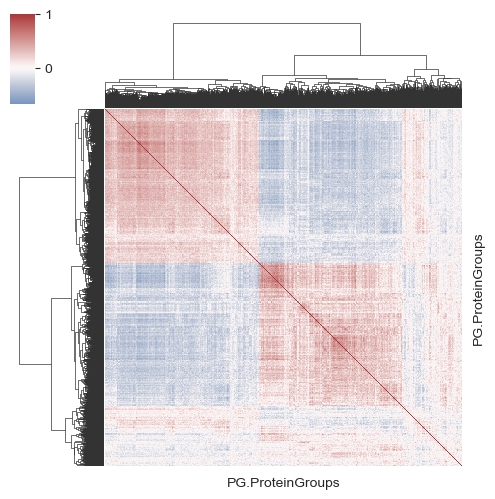

In [13]:
import seaborn as sns
import pandas as pd
import numpy as np
corr = data.T.corr(method = 'spearman')

anno = corr['P62805'].reset_index()
anno.index = corr.index

cmap = plt.cm.get_cmap('vlag')

# Assign color gradient to 'H4_corr' column
anno['H4_corr'] = anno['P62805'].apply(lambda x: cmap(x))
anno['H4_corr'] = anno['P62805'].apply(lambda x: cmap(x))

sns.clustermap(corr, cmap='vlag', figsize=(5,5), center= 0, yticklabels=False, xticklabels=False)

/Users/valdemaras/Programs/miniconda/miniconda3/envs/singlecell/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


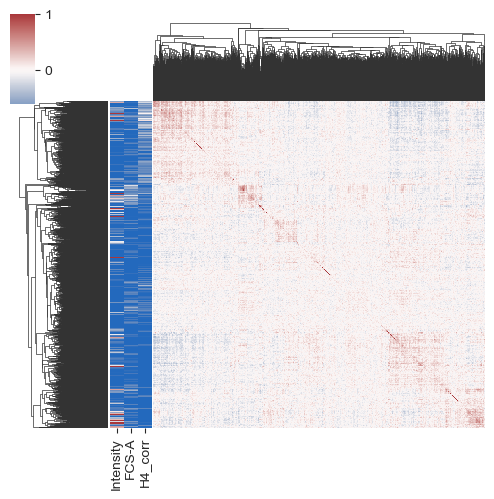

In [14]:
import numpy as np
summary3 = summary2.merge(sc_quant.quant_imputed.T.reset_index(), left_on='File_Name', right_on='index')
summary3.columns.values[0:20]

fcs = pd.concat([summary3.iloc[:,11],summary3.iloc[:,26:]], axis =1)


#Normalization attemps 

#fcs = fcs.apply(lambda x: (x - np.nanmedian(x)/np.nanstd(x)), axis = 0)
#fcs = fcs.apply(lambda x: (x - np.nanmedian(x))/np.nanstd(x), axis = 1)

#fcs = fcs.apply(lambda x: (x - np.nanmean(x)/np.nanstd(x)), axis = 0)
#fcs = fcs.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1)

#Robuts log2 transformed 
fcs = np.log2(fcs).apply(lambda x: (x - np.nanmedian(x)), axis = 0)

fcs = fcs.apply(lambda x: (x - np.nanmedian(x)), axis = 1)
fsc = np.power(fcs,2)


#Softer normalization 

#fcs_medians = fcs.apply(lambda x: np.nanmedian(np.log2(x)), axis = 0).values
#fsc_correction = fcs_medians/np.median(fcs_medians)
#fcs = fcs/fsc_correction
#fcs = np.log2(fcs).apply(lambda x: (x - np.nanmedian(x)), axis = 1)
#fsc = np.power(fcs,2)


fcs2 = fcs.corr(method='spearman')

intensity = data.apply(lambda x: np.nanmedian(x), axis =1).reset_index()

anno = fcs2[['P62805','FSC-A']].reset_index()
anno = anno.merge(intensity, right_on = 'PG.ProteinGroups', left_on = 'index')
anno.index = anno['index'].values

anno.columns = ['index', 'P62805', 'FSC-A', 'PG.ProteinGroups', 'Intensity']

#anno['FCS-A'] = np.where(anno['FSC-A'] > 0.0, 'r', 'b')
#anno['H4_corr'] = np.where(anno['P62805'] > 0.0, 'r', 'b')

cmap = plt.cm.get_cmap('vlag')

# Assign color gradient to 'FCS-A' column
anno['FCS-A'] = anno['FSC-A'].apply(lambda x: cmap(x))

# Assign color gradient to 'H4_corr' column
anno['H4_corr'] = anno['P62805'].apply(lambda x: cmap(x))

# Assign color gradient to 'Intensity' column
anno['Intensity'] = anno['Intensity'].apply(lambda x: cmap(x))

myClusterMap = sns.clustermap(fcs2, cmap='vlag', figsize=(5,5), center= 0, yticklabels=False, xticklabels=False, row_colors= anno.loc[:,anno.columns.isin(['FCS-A','H4_corr', 'Intensity'])])


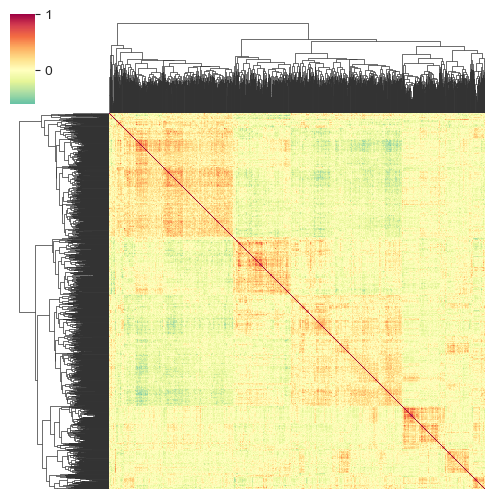

In [15]:
leave_out = (fcs2.apply(lambda x: np.abs(x) > 0.3, axis = 0).sum() > 10).values

fcs3 = fcs2.loc[leave_out,leave_out]

mymap = sns.clustermap(fcs3, cmap='Spectral_r', figsize=(5,5), center= 0, yticklabels=False, xticklabels=False)

In [16]:
fcs4 = fcs3.iloc[mymap.dendrogram_row.reordered_ind, mymap.dendrogram_col.reordered_ind]

In [17]:
(fcs3 > 1).sum().sum()

0

In [18]:
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

#complete_clustering = linkage(fcs2, method="complete", metric="euclidean")
average_clustering = linkage(fcs3, method="average", metric="euclidean")
#single_clustering = linkage(scaled_data, method="single", metric="euclidean")


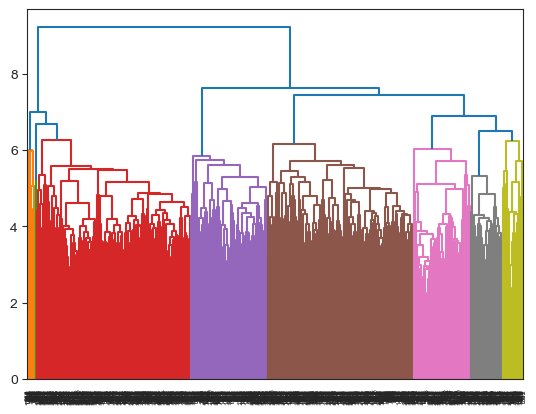

In [19]:
dendrogram(average_clustering)
plt.show()

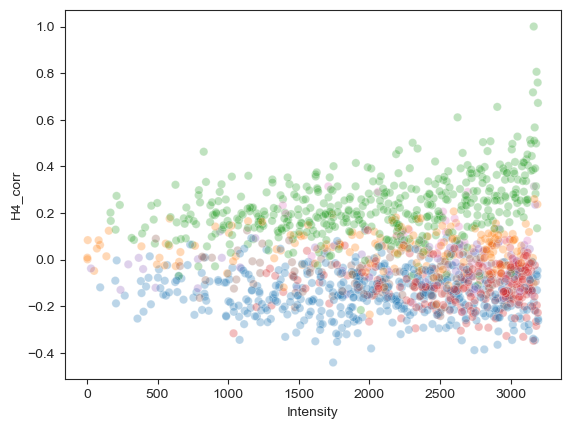

In [20]:
cluster_df = pd.DataFrame({'Cluster': cut_tree(average_clustering, n_clusters=8).reshape(-1, ), 'Protein': fcs3.index})

### Check if there is any protein intensity dependence on H$ correlation
intensity = sc_quant.quant_imputed.apply(lambda x: np.nanmedian(np.log2(x)), axis = 1).rank().reset_index()

#corr_h4 = fcs2['FSC-A'].reset_index();corr_h4.columns = ['PG.ProteinGroups', 'H4_corr']

corr_h4 = fcs3['P62805'].reset_index();corr_h4.columns = ['PG.ProteinGroups', 'H4_corr']

corr_intensity = intensity.merge(corr_h4, on = 'PG.ProteinGroups')

corr_intensity.columns = ['Protein', 'Intensity', 'H4_corr']
corr_intensity = corr_intensity.merge(cluster_df, left_on = 'Protein', right_on = 'Protein')
corr_intensity['Cluster'] = corr_intensity['Cluster'].astype('str')

sns.scatterplot(data = corr_intensity, x = 'Intensity', y = 'H4_corr', alpha = 0.3, hue = 'Cluster', legend = False)

cluster_df.to_csv('data/Exp5/output/cluster_df.txt', sep = "\t", index = False)

/Users/valdemaras/Programs/miniconda/miniconda3/envs/singlecell/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


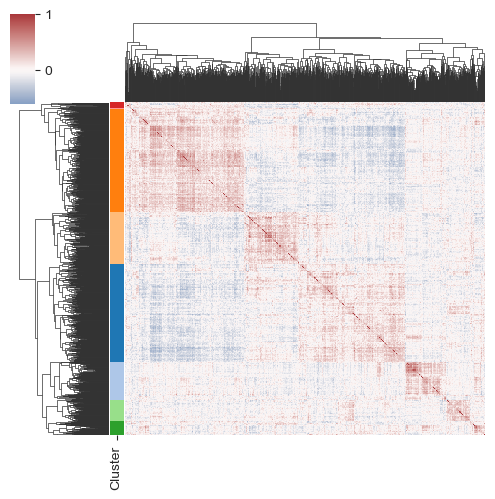

In [21]:
corr_intensity.index = corr_intensity.Protein.values
clusters = corr_intensity.Cluster
lut = dict(zip(clusters.unique(), plt.cm.tab20(range(30))))
row_colors = clusters.map(lut)

sns.clustermap(fcs3, cmap='vlag', figsize=(5,5), center= 0, yticklabels=False, xticklabels=False, row_colors= row_colors)

#### Pathway analysis

In [22]:
import gseapy as gp
from gseapy import Biomart

In [23]:
myClusters = corr_intensity.merge(sc[['PG.ProteinGroups', 'PG.Genes']], left_on = 'Protein', right_on = 'PG.ProteinGroups', how='left')

bkg = sc['PG.Genes'].str.split(';').explode().to_list()
gene_sets=['KEGG_2016','KEGG_2013']

myClusters['PG.Genes'] = myClusters['PG.Genes'].str.split(';')
myClusters = myClusters.explode('PG.Genes')
myClusters = myClusters[myClusters['PG.Genes'].notnull()]

c0 = myClusters.loc[(myClusters.Cluster == '0'),  'PG.Genes']
c1 = myClusters.loc[(myClusters.Cluster == '1'),  'PG.Genes']
c2 = myClusters.loc[(myClusters.Cluster == '2'),  'PG.Genes']
c3 = myClusters.loc[(myClusters.Cluster == '3'),  'PG.Genes']
c4 = myClusters.loc[(myClusters.Cluster == '4'),  'PG.Genes']
c5 = myClusters.loc[(myClusters.Cluster == '5'),  'PG.Genes']
c6 = myClusters.loc[(myClusters.Cluster == '6'),  'PG.Genes']
c7 = myClusters.loc[(myClusters.Cluster == '7'),  'PG.Genes']

In [24]:
(myClusters.value_counts('Cluster'))

Cluster
2    501
1    461
3    234
0    172
5     97
4     67
6     24
7      4
dtype: int64

In [25]:
myClusters.loc[myClusters.Cluster == '1',:]['PG.Genes'].values

array(['GATD3B', 'GATD3A', 'USP17L3', 'USP17L5', 'USP17L15', 'USP17L10',
       'USP17L13', 'USP17L12', 'USP17L11', 'USP17L21', 'USP17L18',
       'USP17L22', 'USP17L17', 'USP17L19', 'USP17L20', 'USP17L24',
       'USP17L1', 'CXorf49', 'MCRIP1', 'DNASE2', 'MYO1C', 'AP3B1',
       'PSMD11', 'PSMD12', 'PGRMC1', 'DNM1L', 'PPP6C', 'COPE', 'AP3D1',
       'DVL2', 'SCAMP3', 'MYL12B', 'MYL12A', 'HGS', 'ARPC2', 'ARPC3',
       'ARPC5', 'PHGDH', 'PSMD3', 'TPD52L2', 'EPB41L2', 'ACTN4', 'AP1G1',
       'IDH3B', 'CALU', 'PRPSAP2', 'SPAG9', 'KIF5C', 'PLIN3', 'SNX2',
       'WDR1', 'CPNE3', 'ADAMTS4', 'SH3BGRL', 'FLNB', 'CS', 'VPS26A',
       'NDUFB1', 'IDH1', 'SCO1', 'DCTN3', 'ATP5PD', 'ATP5MG', 'SRP72',
       'L', 'NDUFA7', 'MPC2', 'SNAP29', 'AP2A1', 'AIFM1', 'CYB5A',
       'GLUD1', 'CYB5R3', 'CA2', 'NRAS', 'GBA', 'ALDOA', 'CSTB', 'OAT',
       'GAPDH', 'RPN1', 'GNAI2', 'ATP1A1', 'ALDH2', 'HMGN1', 'SLC25A5',
       'ITGB1', 'GSN', 'ATP5F1B', 'TPM3', 'HEXA', 'P4HB', 'CTSD', 'ANXA2',
       'CAPN1

In [26]:
def ORA(target, bkg=bkg):
    enr = gp.enrichr(gene_list=target, # or "./tests/data/gene_list.txt",
                 gene_sets='MSigDB_Hallmark_2020',
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                 background = bkg
                )
    return enr

In [27]:
o0 = ORA(c0).results.head(10)
o0['Cluster'] = '0'

In [28]:
o1 =ORA(c1).results.head(10)
o1['Cluster'] = '1'

In [29]:
o2 =ORA(c2).results.head(10)
o2['Cluster'] = '2'

In [30]:
o3 = ORA(c3).results.head(10)
o3['Cluster'] = '3'

In [31]:
o4 =ORA(c4).results.head(10)
o4['Cluster'] = '4'

In [32]:
o5 =ORA(c5).results.head(10)
o5['Cluster'] = '5'

In [33]:
o6 =ORA(c6).results.head(10)
o6['Cluster'] = '6'

In [34]:
o7 = ORA(c7).results.head(10)
o7['Cluster'] = '7'

In [35]:
ora_results = pd.concat([o0,o1,o2,o3,o4,o5,o6,o7])
ora_results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Cluster
0,MSigDB_Hallmark_2020,Myc Targets V1,8/200,3.197592e-04,1.215085e-02,0,0,5.050926,4.064956e+01,PSMA6;SET;PSMA4;PSMA1;PSMB2;PSMA2;PSMB3;PSMA7,0
1,MSigDB_Hallmark_2020,KRAS Signaling Dn,6/200,7.353193e-03,1.397107e-01,0,0,3.703042,1.819164e+01,KRT4;CALML5;CYP11B2;KRT1;KRT13;KRT5,0
2,MSigDB_Hallmark_2020,Cholesterol Homeostasis,3/74,2.519438e-02,2.685381e-01,0,0,4.999325,1.840319e+01,ATXN2;FABP5;CTNNB1,0
3,MSigDB_Hallmark_2020,Estrogen Response Late,5/200,2.826717e-02,2.685381e-01,0,0,3.051282,1.088104e+01,NCOR2;FABP5;KRT13;S100A9;LTF,0
4,MSigDB_Hallmark_2020,Wnt-beta Catenin Signaling,2/42,4.954801e-02,3.765649e-01,0,0,5.889881,1.769799e+01,NCOR2;CTNNB1,0
...,...,...,...,...,...,...,...,...,...,...,...
0,MSigDB_Hallmark_2020,Myc Targets V1,4/200,9.704079e-09,4.852039e-08,0,0,79200.000000,1.461297e+06,SYNCRIP;HSPE1;RAN;SRM,7
1,MSigDB_Hallmark_2020,Myc Targets V2,2/58,4.940518e-05,1.235130e-04,0,0,356.071429,3.530610e+03,HSPE1;SRM,7
2,MSigDB_Hallmark_2020,E2F Targets,2/200,5.891616e-04,9.819361e-04,0,0,99.989899,7.436059e+02,SYNCRIP;RAN,7
3,MSigDB_Hallmark_2020,G2-M Checkpoint,1/200,3.940669e-02,3.940669e-02,0,0,33.160804,1.072361e+02,SYNCRIP,7


In [37]:
#Export data 

#Change the column names on the fcs3

fcs5 = fcs4.copy()
fcs5.columns = fcs5.columns.str.replace(';', '__')
fcs5.to_csv('data/Exp5/output/correlation_matrix2.txt', sep = "\t")

myClusters.to_csv('data/Exp5/output/Clusters.txt', sep = "\t")
ora_results.to_csv('data/Exp5/output/ORA.txt', sep = "\t")
sc[['PG.ProteinGroups', 'PG.Genes']].to_csv('data/Exp5/output/Proteins_Genes.txt', sep = "\t", index = False)
summary2.to_csv('data/Exp5/output/HEK_summary.txt', sep = "\t", index = False)
